## 1. Project Setup & Environment Configuration


In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Utils
from tqdm import tqdm
tqdm.pandas()

# Settings
pd.set_option("display.max_colwidth", 300)
plt.style.use("seaborn-v0_8")

# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## 2. Dataset Loading (WELFake)


In [ ]:
DATA_PATH = "/content/WELFake_Dataset.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO],No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to turn the tide and kill white people and cops to send a message abo...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO],"Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Eric Holder in a skirt",1
3,3,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid","A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled from Hinduism to Protestant Christianity and, ultimately, became what he calls an “evangelical Cathol...",0
4,4,SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice,"The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggressive Russia It could deliver a warhead of 40 megatons – 2,000 times as powerful as the atom bomb...",1


## 3. Dataset Structure & Schema Inspection


In [ ]:
df.columns


Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


## 4. Missing Value Analysis & Cleanup


In [ ]:
df.isnull().sum()


,0
Unnamed: 0,0
title,558
text,39
label,0


In [ ]:
df.dropna(subset=["title", "text"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("After NaN removal:", df.shape)


After NaN removal: (71537, 4)


## 5. Label Distribution Analysis


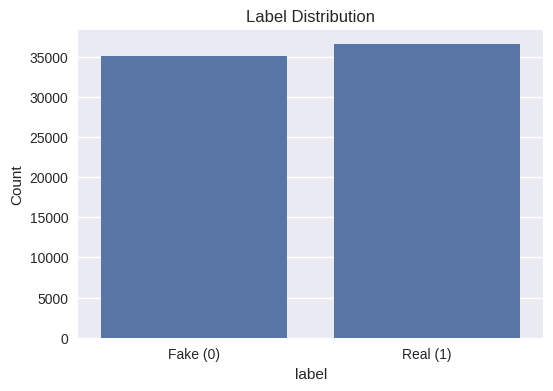

,count
label,
1,36509
0,35028


In [ ]:
label_counts = df["label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0,1], ["Fake (0)", "Real (1)"])
plt.title("Label Distribution")
plt.ylabel("Count")
plt.show()

label_counts


In [ ]:
df["content"] = df["title"] + " " + df["text"]


In [ ]:
# Drop original columns
df.drop(columns=[col for col in ["title", "text", "id"] if col in df.columns],
        inplace=True)

df.head()


,Unnamed: 0,label,content
0,0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO] No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and...
1,2,1,"UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO] Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and ..."
2,3,0,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal trav..."
3,4,1,"SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly aggres..."
4,5,1,"About Time! Christian Group Sues Amazon and SPLC for Designation as Hate Group All we can say on this one is it s about time someone sued the Southern Poverty Law Center!On Tuesday, D. James Kennedy Ministries (DJKM) filed a lawsuit against the Southern Poverty Law Center (SPLC), the charity nav..."


In [ ]:
# Character length
df["char_len"] = df["content"].apply(len)

# Word length
df["word_len"] = df["content"].apply(lambda x: len(x.split()))

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,71537.000000,71537.000000
mean,3370.852356,556.828508
std,3737.750019,626.527077
min,14.000000,2.000000
25%,1490.000000,244.000000
50%,2516.000000,412.000000
75%,4156.000000,683.000000
max,143035.000000,24243.000000


## 8. Exploratory Data Analysis (EDA)


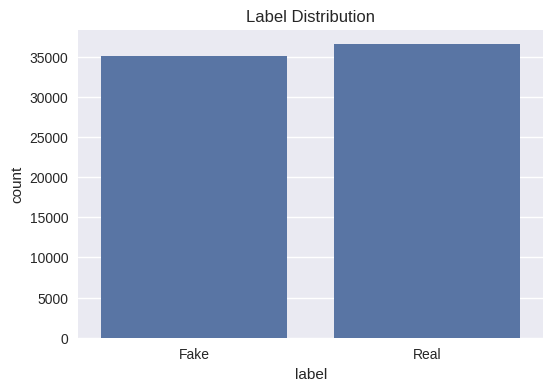

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Label Distribution")
plt.show()


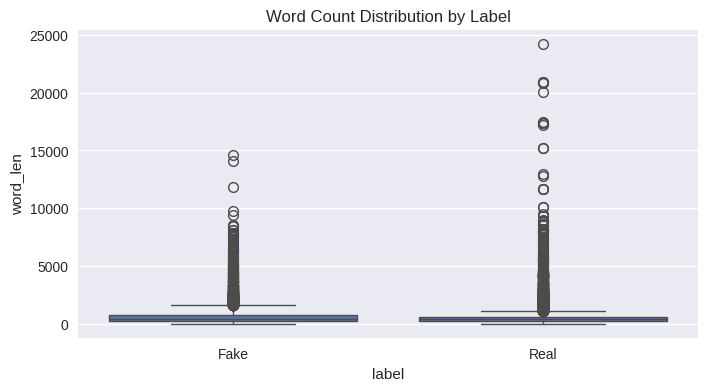

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x="label", y="word_len", data=df)
plt.xticks([0,1], ["Fake", "Real"])
plt.title("Word Count Distribution by Label")
plt.show()


## 9. Text Cleaning & Normalization Pipeline


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
tqdm.pandas()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def clean_text(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenize
    tokens = text.split()

    # Stopword removal + lemmatization
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(tokens)


## 10. Apply Text Cleaning & Final Dataset Preparation


In [ ]:
df["clean_text"] = df["content"].progress_apply(clean_text)


100%|██████████| 71537/71537 [01:27<00:00, 821.21it/s]


In [ ]:
df = df[df["clean_text"].str.len() > 50]
df.reset_index(drop=True, inplace=True)

print("Final shape:", df.shape)


Final shape: (71389, 6)


In [ ]:
df.drop(columns=["content", "char_len", "word_len"], inplace=True)
df.head()


,Unnamed: 0,label,clean_text
0,0,1,law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video comment expected barack obama member fyf fukyoflag blacklivesmatter movement called lynching hanging white people cop encouraged others radio show tuesday night turn tide kill white people cop send message...
1,2,1,unbelievable obama’s attorney general say charlotte rioter “peaceful” protesters…in home state north carolina video demonstrator gathered last night exercising constitutional protected right peaceful protest order raise issue create change loretta lynch aka eric holder skirt
2,3,0,bobby jindal raised hindu us story christian conversion woo evangelicals potential bid dozen politically active pastor came private dinner friday night hear conversion story unique context presidential politics louisiana gov bobby jindal traveled hinduism protestant christianity ultimately becam...
3,4,1,satan russia unvelis image terrifying new ‘supernuke’ western world take notice sarmat missile dubbed satan replace fly mile per sec range mile weapon perceived part increasingly aggressive russia could deliver warhead megaton time powerful atom bomb dropped hiroshima nagasaki libby plummer gare...
4,5,1,time christian group sue amazon splc designation hate group say one time someone sued southern poverty law centeron tuesday james kennedy ministry djkm filed lawsuit southern poverty law center splc charity navigation organization guidestar amazon defamation religious discrimination trafficking ...


## 11. Export Cleaned Dataset


In [ ]:
df_final = df[["clean_text", "label"]]

df_final.to_csv("WELFake_CLEANED.csv", index=False)

print("Saved successfully: WELFake_CLEANED.csv")


Saved successfully: WELFake_CLEANED.csv


## 12. Library Installation


In [ ]:
!pip install -q transformers datasets accelerate evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 23.8 MB/s eta 0:00:00


## 13. Reload Cleaned Dataset


In [ ]:
df = pd.read_csv("WELFake_CLEANED.csv")
df.head()


,clean_text,label
0,law enforcement high alert following threat cop white blacklivesmatter fyf terrorist video comment expected barack obama member fyf fukyoflag blacklivesmatter movement called lynching hanging white people cop encouraged others radio show tuesday night turn tide kill white people cop send message...,1
1,unbelievable obama’s attorney general say charlotte rioter “peaceful” protesters…in home state north carolina video demonstrator gathered last night exercising constitutional protected right peaceful protest order raise issue create change loretta lynch aka eric holder skirt,1
2,bobby jindal raised hindu us story christian conversion woo evangelicals potential bid dozen politically active pastor came private dinner friday night hear conversion story unique context presidential politics louisiana gov bobby jindal traveled hinduism protestant christianity ultimately becam...,0
3,satan russia unvelis image terrifying new ‘supernuke’ western world take notice sarmat missile dubbed satan replace fly mile per sec range mile weapon perceived part increasingly aggressive russia could deliver warhead megaton time powerful atom bomb dropped hiroshima nagasaki libby plummer gare...,1
4,time christian group sue amazon splc designation hate group say one time someone sued southern poverty law centeron tuesday james kennedy ministry djkm filed lawsuit southern poverty law center splc charity navigation organization guidestar amazon defamation religious discrimination trafficking ...,1


In [ ]:
df["label"].value_counts(normalize=True)


,proportion
label,
1,0.50935
0,0.49065


## 14. Train / Validation / Test Split


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

print(len(train_df), len(val_df), len(test_df))


57111 7139 7139


## 15. HuggingFace Dataset Conversion


In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)


In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 17. Tokenization (256 Token Context)


In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )


In [ ]:
train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)


Map:   0%|          | 0/57111 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

## 18. Torch Dataset Formatting


In [ ]:
train_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


## 19. Model Initialization (DistilBERT)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 20. Evaluation Metrics Definition


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }


## 21. Training Configuration


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)


## 22. Model Training


In [ ]:
from transformers import Trainer
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    weight_decay=0.01,
    fused=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

/tmp/ipython-input-2713437785.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.069000,0.057542,0.983331,0.983714
2,0.038300,0.049910,0.988234,0.988417
3,0.013600,0.059908,0.988934,0.989132


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=10710, training_loss=0.046228041980558195, metrics={'train_runtime': 1164.2835, 'train_samples_per_second': 147.181, 'train_steps_per_second': 9.199, 'total_flos': 1.1348018406964224e+16, 'train_loss': 0.046228041980558195, 'epoch': 3.0})

## 23. Model Evaluation on Test Set


In [ ]:
trainer.evaluate(test_ds)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04332472383975983,
 'eval_accuracy': 0.9917355371900827,
 'eval_f1': 0.9918855728235456,
 'eval_runtime': 11.141,
 'eval_samples_per_second': 641.953,
 'eval_steps_per_second': 40.122,
 'epoch': 3.0}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred, digits=4))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9914    0.9917    0.9916      3503
           1     0.9920    0.9917    0.9919      3636

    accuracy                         0.9917      7139
   macro avg     0.9917    0.9917    0.9917      7139
weighted avg     0.9917    0.9917    0.9917      7139



## 24. Probability Outputs & Confidence Scores


In [ ]:
import numpy as np

preds = trainer.predict(test_ds)

y_true = preds.label_ids
y_logits = preds.predictions
y_pred = np.argmax(y_logits, axis=1)
y_probs = y_logits[:, 1]


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## 25. Confusion Matrix Analysis


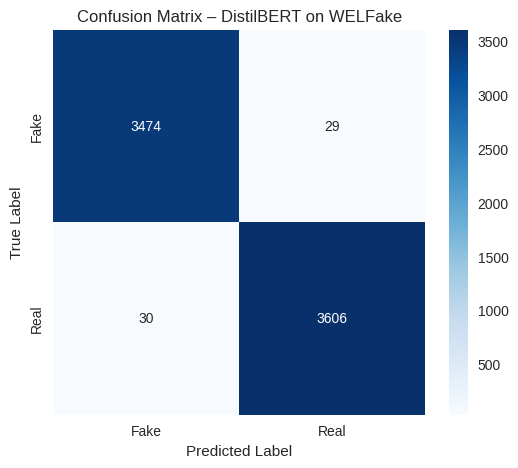

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – DistilBERT on WELFake")
plt.show()


## 26. ROC–AUC Analysis


ROC–AUC Score: 0.9995


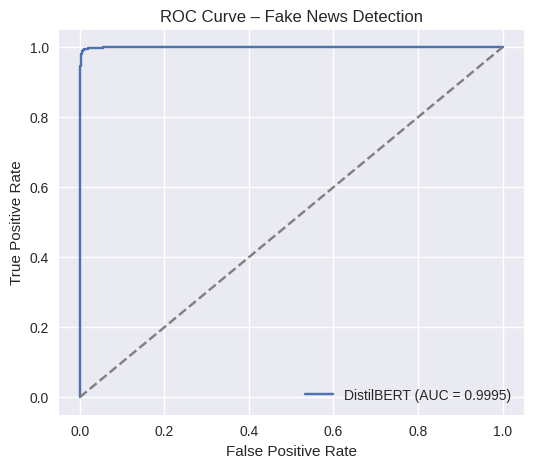

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_true, y_probs)
print(f"ROC–AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"DistilBERT (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Fake News Detection")
plt.legend()
plt.show()


## 27. Error Analysis & Misclassification Inspection


In [ ]:
errors = test_df.copy()
errors["true_label"] = y_true
errors["pred_label"] = y_pred

misclassified = errors[errors["true_label"] != errors["pred_label"]]
print("Total misclassified samples:", len(misclassified))


Total misclassified samples: 59


In [ ]:
misclassified.sample(5)[["clean_text", "true_label", "pred_label"]]


,clean_text,true_label,pred_label
18848,video exobama staffer urged spying trump predicted ‘quick’ impeachment week election tel aviv speaking conference two week presidential election evelyn farkas former top obama administration official predicted donald trump presidency would “be impeached pretty quickly somebody else would take go...,0,1
12412,syrian airstrike may open door congressional funding refugee safe zone overseas last week’s american airstrike syrian base believed house chemical weapon used attack syrian civilian brought issue refugee forefront political debate democrat ranging hillary clinton maxine water used airstrike oppo...,0,1
37048,new york time ‘rededicate’ journalism election fail last wednesday many american shocked woke news donald trump elected president day surprise undoubtedly result trusting mainstream medium providing fair accurate coverage trump clinton’s election prospect turn trust seriously misplaced washingto...,1,0
7062,edgar comey intended use final column presidential election explain length cannot vote either hillary clinton donald trump plan vote gary johnson president nutshell big government biggest problem thrives debt tax regulation war secretive deep state less personal freedom clinton trump would grow ...,1,0
27946,doj loretta lynch advised fbi director keep new email congress according report attorney general loretta lynch advised fbi director james comey send letter congress would inform new email agency discovered investigation hillary clinton illegal email server new yorker reported friday james comey ...,1,0


In [ ]:
misclassified.groupby(["true_label", "pred_label"]).size()


,,0
true_label,pred_label,
0,1,29
1,0,30


## 28. Robustness Stress Test — Reduced Context (128 Tokens)


In [ ]:
def tokenize_short(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds_short = train_ds.map(tokenize_short, batched=True)
val_ds_short   = val_ds.map(tokenize_short, batched=True)
test_ds_short  = test_ds.map(tokenize_short, batched=True)

train_ds_short.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds_short.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds_short.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/57111 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

## 29. Stress Test Training Configuration


In [ ]:
from transformers import TrainingArguments

training_args_short = TrainingArguments(
    output_dir="./results_short",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",

    optim="adamw_torch"
)


## 30. Stress Test Model Training


In [ ]:
from transformers import AutoModelForSequenceClassification

model_short = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

trainer_short = Trainer(
    model=model_short,
    args=training_args_short,
    train_dataset=train_ds_short,
    eval_dataset=val_ds_short,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-359554910.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_short = Trainer(


In [ ]:
trainer_short.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.074600,0.057031,0.981790,0.982069
2,0.032000,0.059891,0.986553,0.986788


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=7140, training_loss=0.07116780448026684, metrics={'train_runtime': 778.0371, 'train_samples_per_second': 146.831, 'train_steps_per_second': 9.177, 'total_flos': 3782672802321408.0, 'train_loss': 0.07116780448026684, 'epoch': 2.0})

## 31. Stress Test Evaluation


In [ ]:
trainer_short.evaluate(test_ds_short)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04998399689793587,
 'eval_accuracy': 0.9883737218097772,
 'eval_f1': 0.9885847888873608,
 'eval_runtime': 8.6308,
 'eval_samples_per_second': 828.664,
 'eval_steps_per_second': 51.792,
 'epoch': 2.0}

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

preds_short = trainer_short.predict(test_ds_short)
y_true_short = preds_short.label_ids
y_pred_short = np.argmax(preds_short.predictions, axis=1)

print(classification_report(y_true_short, y_pred_short, digits=4))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

           0     0.9880    0.9883    0.9882      3503
           1     0.9887    0.9884    0.9886      3636

    accuracy                         0.9884      7139
   macro avg     0.9884    0.9884    0.9884      7139
weighted avg     0.9884    0.9884    0.9884      7139



## 32. Performance Comparison (Main vs Stress Test)


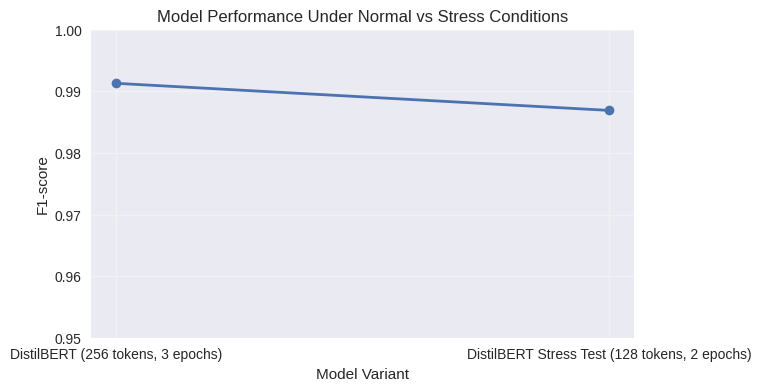

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))

plt.plot(results["Model"], results["F1_score"], marker="o", linewidth=2)
plt.ylim(0.95, 1.0)

plt.title("Model Performance Under Normal vs Stress Conditions")
plt.ylabel("F1-score")
plt.xlabel("Model Variant")

plt.grid(alpha=0.3)
plt.show()


In [ ]:
results = pd.DataFrame({
    "Model": [
        "DistilBERT (256 tokens, 3 epochs)",
        "DistilBERT Stress Test (128 tokens, 2 epochs)"
    ],
    "Accuracy": [0.9913, 0.9867],
    "F1_score": [0.9913, 0.9869]
})


In [ ]:
results["F1_drop_%"] = (
    (results.loc[0, "F1_score"] - results["F1_score"])
    / results.loc[0, "F1_score"]
) * 100

results


,Model,Accuracy,F1_score,F1_drop_%
0,"DistilBERT (256 tokens, 3 epochs)",0.9913,0.9913,0.000000
1,"DistilBERT Stress Test (128 tokens, 2 epochs)",0.9867,0.9869,0.443862


## 33. Robustness Verification (Assertion-Based)


In [ ]:
assert results.loc[1, "F1_score"] >= 0.97, \
    "Stress test failed: model performance dropped significantly"


## 34. Class-wise Stability Analysis


In [ ]:
results.style.format({
    "Accuracy": "{:.4f}",
    "F1_score": "{:.4f}",
    "F1_drop_%": "{:.2f}%"
}).set_caption(
    "Final Performance Comparison: Standard Training vs Robustness Stress Test"
)


,Model,Accuracy,F1_score,F1_drop_%
0,"DistilBERT (256 tokens, 3 epochs)",0.9913,0.9913,0.00%
1,"DistilBERT Stress Test (128 tokens, 2 epochs)",0.9867,0.9869,0.44%


In [ ]:
import pandas as pd

class_results = pd.DataFrame({
    "Class": ["Fake News (0)", "Real News (1)"],
    "Main_Model_F1": [0.9912, 0.9915],
    "Stress_Test_F1": [0.9864, 0.9869]
})

class_results


,Class,Main_Model_F1,Stress_Test_F1
0,Fake News (0),0.9912,0.9864
1,Real News (1),0.9915,0.9869


In [ ]:
class_results["F1_drop_%"] = (
    (class_results["Main_Model_F1"] - class_results["Stress_Test_F1"])
    / class_results["Main_Model_F1"]
) * 100

class_results


,Class,Main_Model_F1,Stress_Test_F1,F1_drop_%
0,Fake News (0),0.9912,0.9864,0.484262
1,Real News (1),0.9915,0.9869,0.463944


## 35. Fake vs Real Detection Stability Visualization


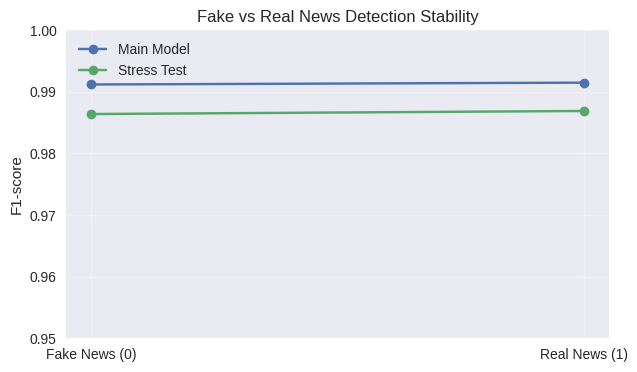

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))

plt.plot(class_results["Class"], class_results["Main_Model_F1"],
         marker="o", label="Main Model")
plt.plot(class_results["Class"], class_results["Stress_Test_F1"],
         marker="o", label="Stress Test")

plt.ylim(0.95, 1.0)
plt.ylabel("F1-score")
plt.title("Fake vs Real News Detection Stability")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## 36. Confidence Separation Analysis


In [ ]:
import numpy as np

confidence_gap = abs(
    np.mean(y_probs[y_true == 1]) -
    np.mean(y_probs[y_true == 0])
)

confidence_gap


np.float32(10.000704)